In [18]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
## Data Cleaning
# Get energy dummy
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# Change constructing year to construction age and squared term for OLS.
df['age'] = 2023 - df['year']
df['age_squared'] = df['age'] ** 2

# Price per squared metre
df['price_per_m2'] = df['price'] / df['living_space']

In [14]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'price_per_m2']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X)

      saledays  living_space  ground_space  rooms  owner_expenses  area_code  \
0        202.0         170.0        1019.0    2.0           2.598     4591.0   
1          0.0          94.0           0.0    3.0           2.389     2100.0   
2        255.0         248.0         984.0    8.0           8.643     2900.0   
3          7.0         107.0           0.0    3.0           3.849     8000.0   
4          0.0         163.0         858.0    5.0           3.343     7100.0   
...        ...           ...           ...    ...             ...        ...   
3645      48.0         109.0         506.0    3.0           1.922     5250.0   
3646      48.0         117.0         800.0    3.0           1.566     7620.0   
3647     240.0          86.0         103.0    4.0           2.184     3320.0   
3648      48.0          79.0         829.0    3.0           1.464     7160.0   
3649      48.0         133.0         129.0    5.0           4.615     8240.0   

      Apartment  Holiday home  Terraced

<AxesSubplot: >

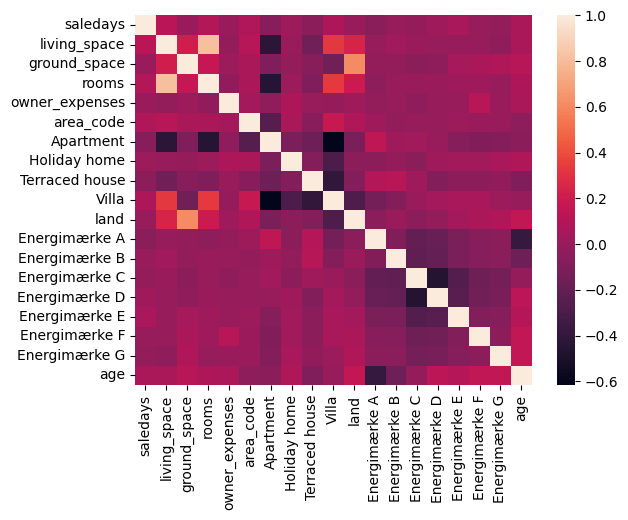

In [20]:
## Heat map
sns.heatmap(X.corr())


In [8]:
## Main model
eta = 0.1
gradient_booster = HistGradientBoostingClassifier(learning_rate=eta)
# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict = gradient_booster.predict(X_test)
print(classification_report(y_test,y_test_predict))
# Use the Python module named classification report to verify the correctness and quality of the accuracy report ().

              precision    recall  f1-score   support

      200000       0.00      0.00      0.00         1
      295000       0.00      0.00      0.00         1
      345000       0.00      0.00      0.00         1
      350000       0.00      0.00      0.00         2
      370000       0.00      0.00      0.00         1
      395000       0.00      0.00      0.00         3
      405000       0.00      0.00      0.00         1
      425000       0.00      0.00      0.00         1
      435000       0.00      0.00      0.00         1
      445000       0.00      0.00      0.00         1
      465000       0.00      0.00      0.00         1
      475000       0.00      0.00      0.00         2
      495000       0.00      0.00      0.00         8
      520000       0.00      0.00      0.00         1
      525000       0.00      0.00      0.00         2
      545000       0.00      0.00      0.00         2
      550000       0.00      0.00      0.00         3
      555000       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [1]:
## Lasso regularization
# Normal scaler
from sklearn.preprocessing import StandardScaler
norm_scaler = StandardScaler().fit(X_train)
X_train_std = norm_scaler.transform(X_train)
X_test_std = norm_scaler.transform(X_test)

# Lasso
from sklearn.linear_model import Lasso
output = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    reg = Lasso(alpha=lambda_, random_state=1)
    reg.fit(X_train_std, y_train)
    output.append(
        [
            lambda_,
            mse(reg.predict(X_train_std), y_train,squared=False),
            mse(reg.predict(X_test_std), y_test,squared=False),
        ]
    )

NameError: name 'X_train' is not defined

In [ ]:
## Search for best lambda
MSE_df = pd.DataFrame(
    data=output, columns=["lambda", "MSE train", "MSE test"]
).set_index("lambda")

MSE_df.plot(logx=True, logy=True)

# find the minimal observations as a series
best_fit = MSE_df["MSE test"].nsmallest(1)

# take out the data minimum RMSE and the optimal lambda
lambda_opt, RMSE_min = next(best_fit.items())
print(f"Minimum RMSE = {RMSE_min:.3f} found for lambda = {lambda_opt:.4f}.")


In [ ]:
## 5-fold cross validation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
# Pipeline
pipe_lasso = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    Lasso(random_state=1),
)

# Split X, y into development (2/3) and test data (1/3).
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=(1 / 3), random_state=1)

lambdas = np.logspace(-4, 4, 12)

kfolds = KFold(n_splits=5)
mses = []

for lambda_ in lambdas:

    pipe_lasso = make_pipeline(
        PolynomialFeatures(degree=3, include_bias=False),
        StandardScaler(),
        Lasso(alpha=lambda_, random_state=1),
    )
    mses_test = []
    mses_train = []

    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx]

        pipe_lasso.fit(X_train, y_train)

        mses_train.append(mse(pipe_lasso.predict(X_train), y_train))
        mses_test.append(mse(pipe_lasso.predict(X_val), y_val))

    mses.append([np.mean(mses_train), np.mean(mses_test), lambda_])

# Create df with MSE values
df_mses = pd.DataFrame(mses, columns=["MSE_train", "MSE_test", "lambda"])

# Index of the lambda that gives the lowest MSE_test in the dataframe
idx_optimal_lambda = df_mses.idxmin()["MSE_test"]
lambda_opt_test = df_mses.loc[idx_optimal_lambda]["lambda"]
opt_test_mse = df_mses.loc[idx_optimal_lambda]["MSE_test"]
print(
    f"Lowest test MSE equal to {opt_test_mse:.4f} is"
    f" achieved with lambda = {lambda_opt_test:.3f}."
)

In [ ]:
## Root mean squared errors
# rmse_GBM = mse(y_test,y_test_predict,squared=False)
# rmse_GBM

In [9]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

-0.12810011020131395